In [1187]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor

# File Reading

In [1188]:
df = pd.read_csv("used_cars.csv")
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


# Type converion

In [1189]:
df["clean_title"] = df["clean_title"].fillna("No reports")
df["clean_title"] = pd.get_dummies(df["clean_title"], drop_first=True)
df["clean_title"] = df['clean_title'].astype(int)
df["accident"] = pd.get_dummies(df["accident"], drop_first=True)
df["accident"] = df['accident'].astype(int)
df["milage"] = pd.to_numeric(df["milage"].map(lambda x: x.replace(" mi.","").replace(",", "")))
df["price"] = pd.to_numeric(df["price"].map(lambda x: x[1:].replace(",","")))

In [1190]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   brand         4009 non-null   str  
 1   model         4009 non-null   str  
 2   model_year    4009 non-null   int64
 3   milage        4009 non-null   int64
 4   fuel_type     3839 non-null   str  
 5   engine        4009 non-null   str  
 6   transmission  4009 non-null   str  
 7   ext_col       4009 non-null   str  
 8   int_col       4009 non-null   str  
 9   accident      4009 non-null   int64
 10  clean_title   4009 non-null   int64
 11  price         4009 non-null   int64
dtypes: int64(5), str(7)
memory usage: 376.0 KB


# EDA

In [1191]:
df.describe().round(2)

,model_year,milage,accident,clean_title,price
count,4009.00,4009.00,4009.00,4009.00,4009.00
mean,2015.52,64717.55,0.73,0.85,44553.19
std,6.10,52296.60,0.45,0.36,78710.64
min,1974.00,100.00,0.00,0.00,2000.00
25%,2012.00,23044.00,0.00,1.00,17200.00
50%,2017.00,52775.00,1.00,1.00,31000.00
75%,2020.00,94100.00,1.00,1.00,49990.00
max,2024.00,405000.00,1.00,1.00,2954083.00


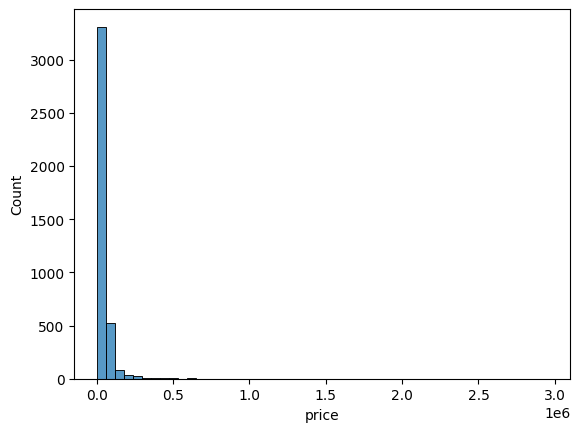

In [1192]:
sns.histplot(df['price'], bins=50)
plt.show()

<Axes: xlabel='price', ylabel='Count'>

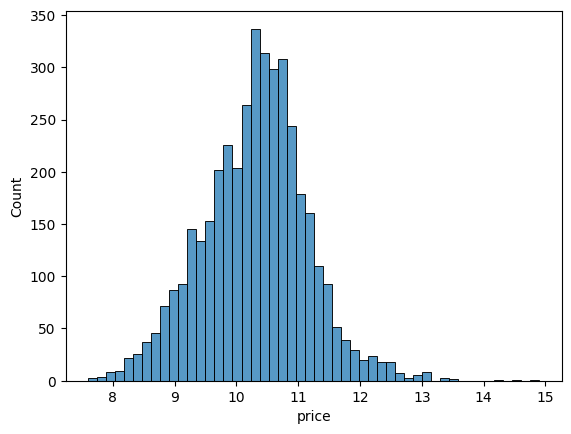

In [1193]:
sns.histplot(np.log1p(df['price']), bins=50)

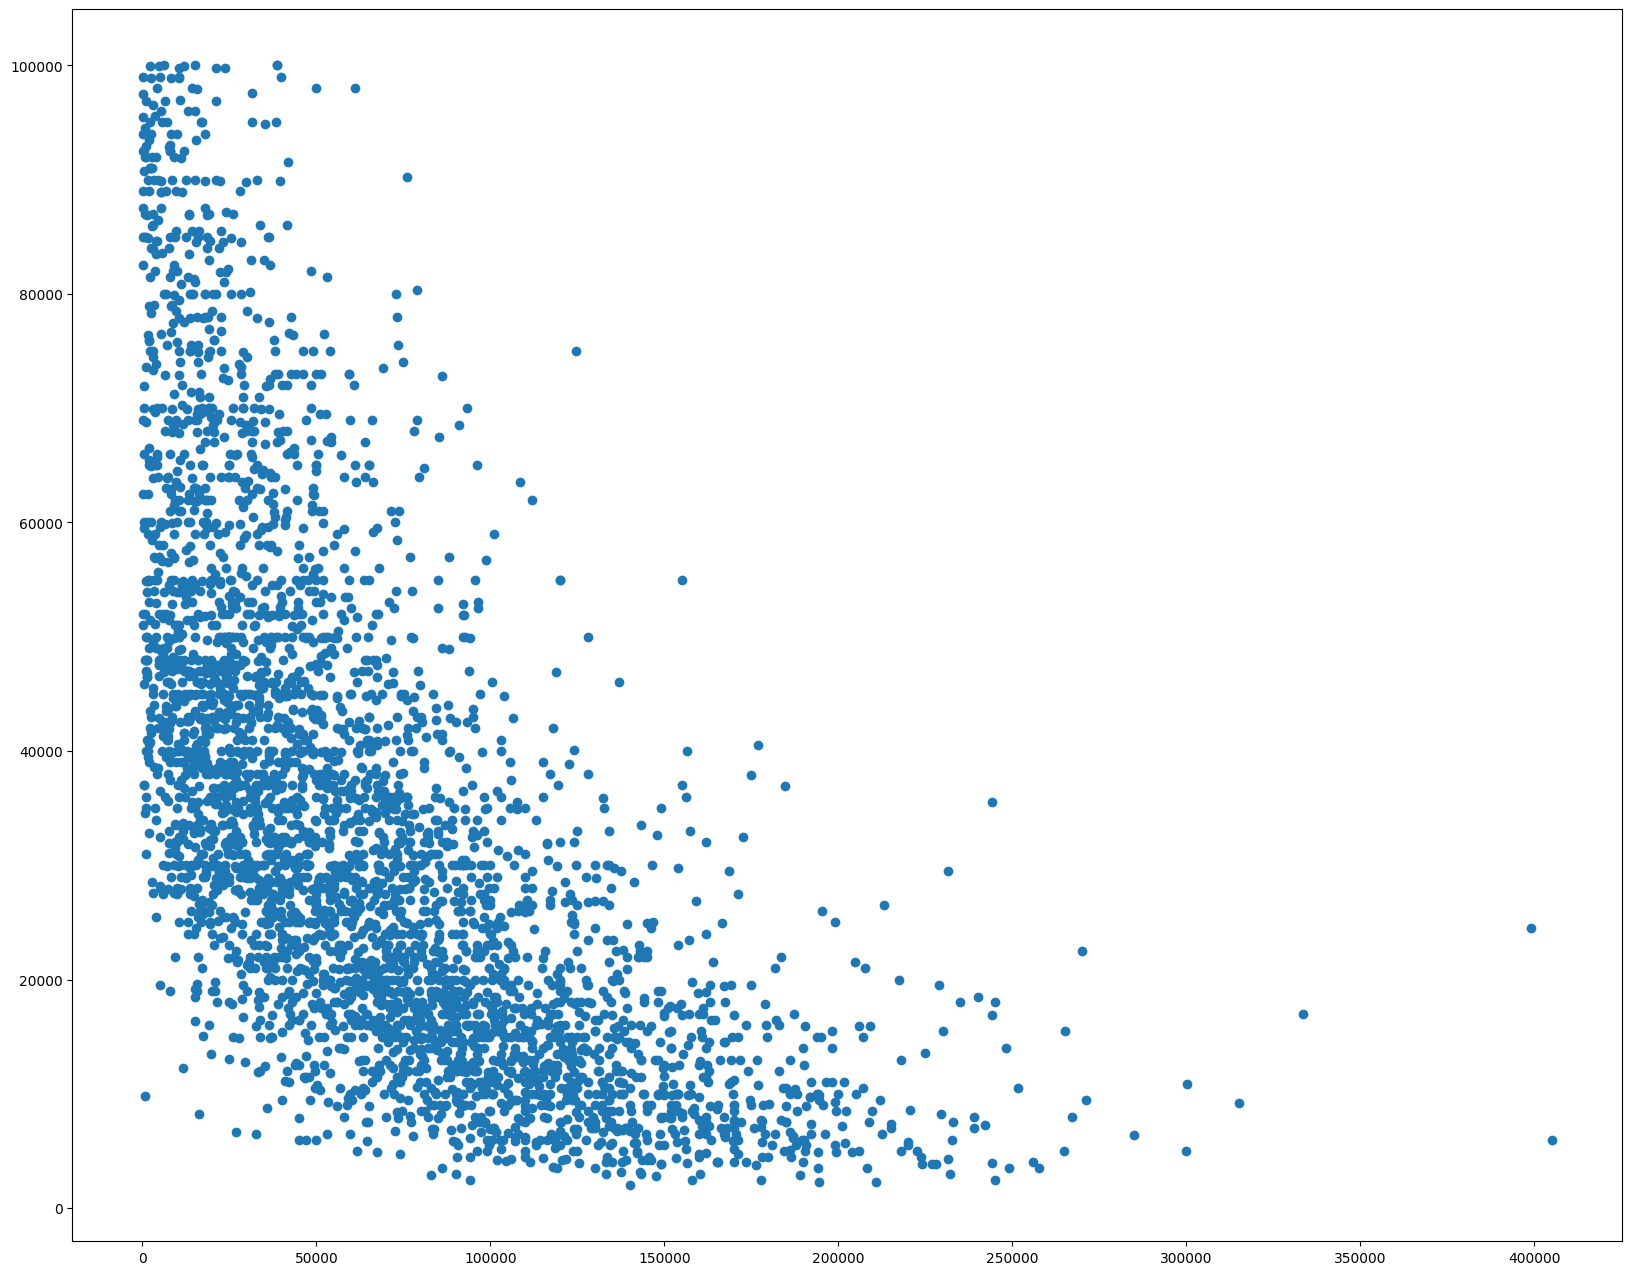

In [1194]:
plt.figure(figsize=(20,16))
plt.scatter(df[df["price"]<=100000]["milage"], df[df["price"]<=100000]["price"])

array([[<Axes: title={'center': 'model_year'}>,
        <Axes: title={'center': 'milage'}>],
       [<Axes: title={'center': 'accident'}>,
        <Axes: title={'center': 'clean_title'}>],
       [<Axes: title={'center': 'price'}>, <Axes: >]], dtype=object)

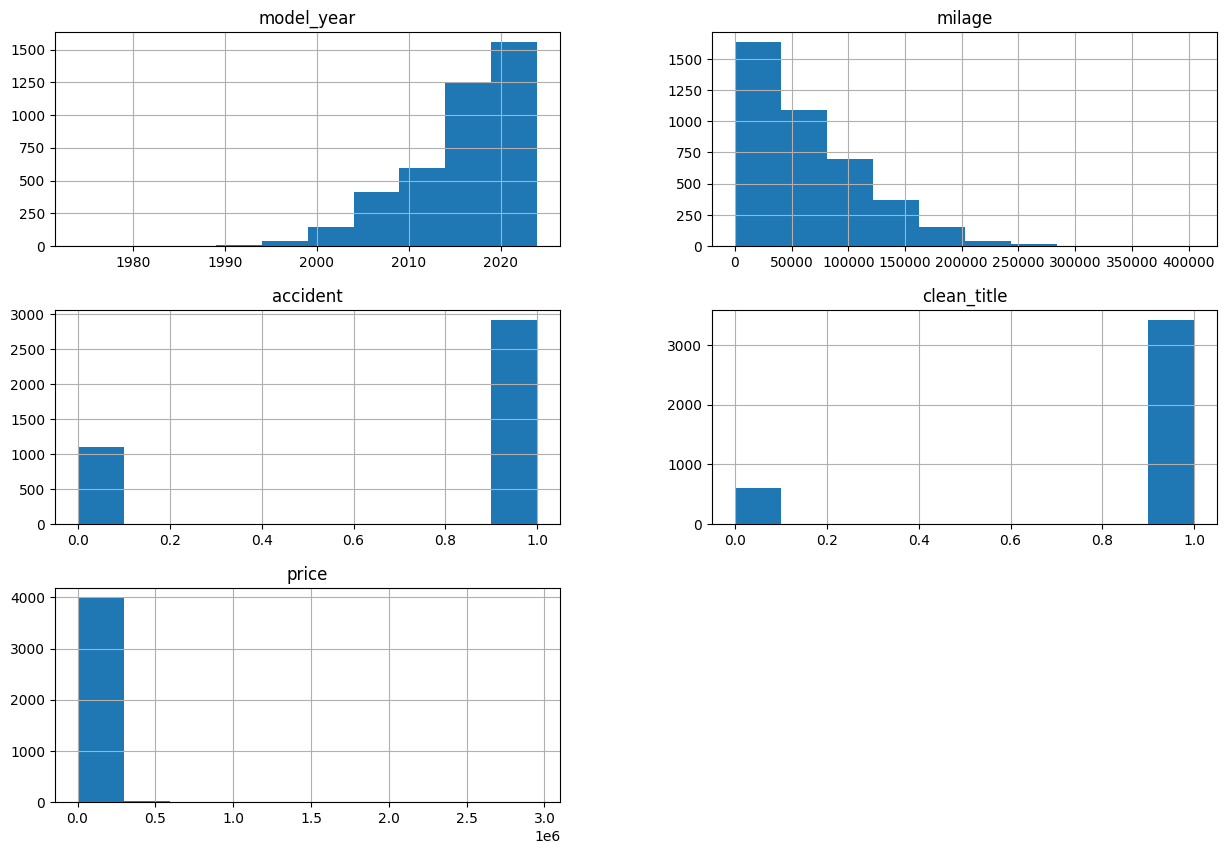

In [1195]:
df.hist(figsize=(15,10))

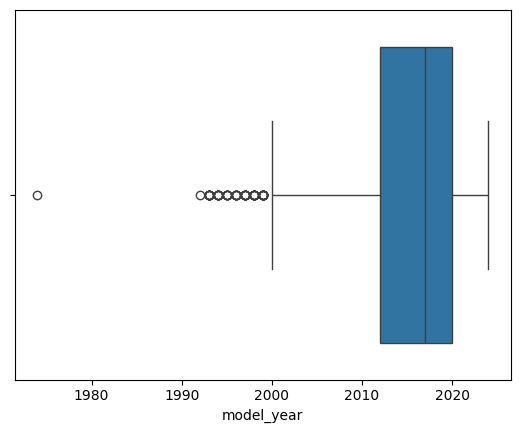

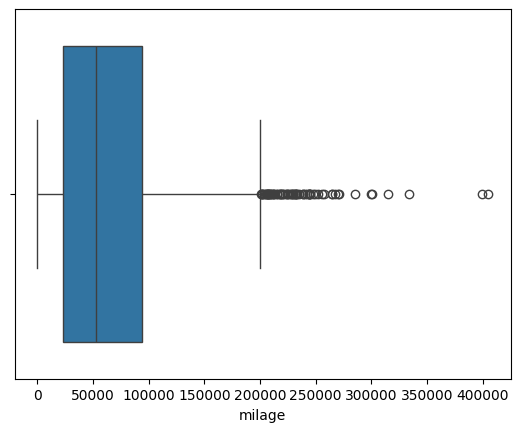

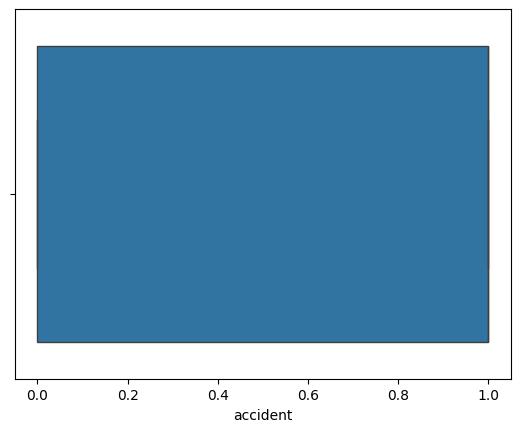

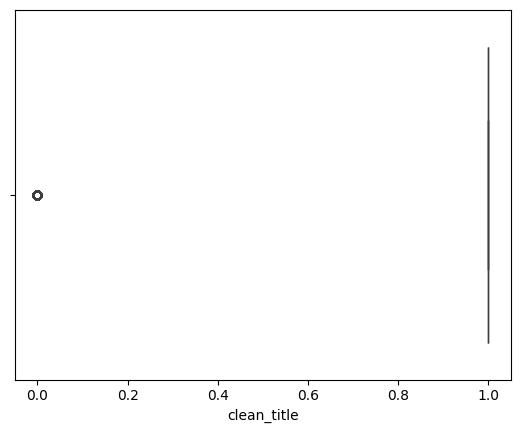

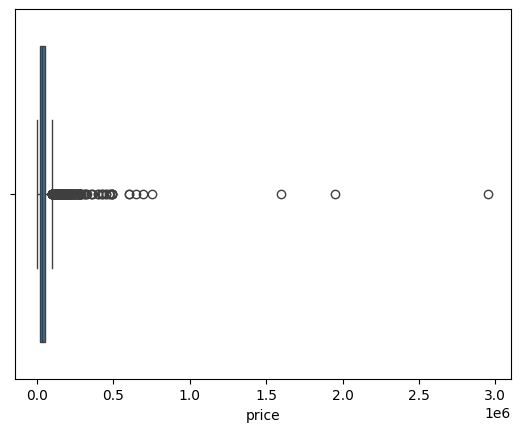

In [1196]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_cols:
    sns.boxplot(x=df[col])
    plt.show()

# Correlation matrixx


<Axes: >

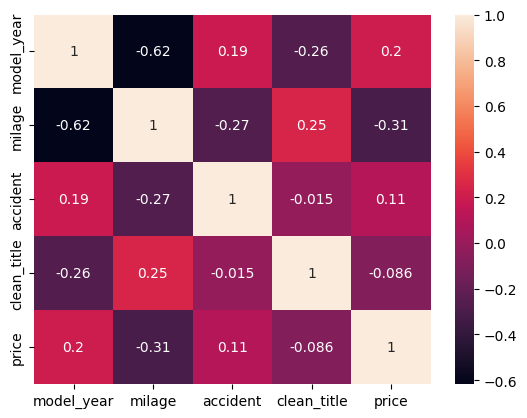

In [1197]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
sns.heatmap(df[numeric_cols].corr(), annot=True)

Заменим кореллированые признаки model_year и mileage на один признак avg_mileage_year

<Axes: >

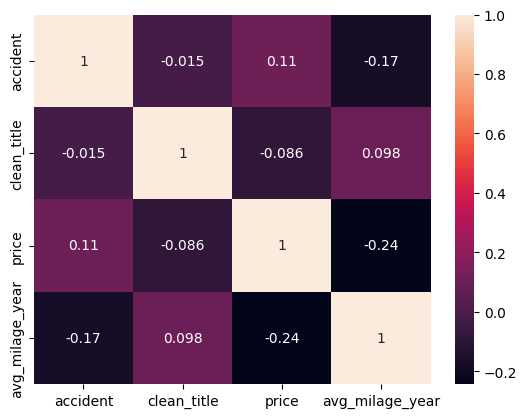

In [1198]:
df["age"] = 2025 - df["model_year"]
df["avg_milage_year"]  = (df["milage"] / df["age"]).round(2)
df = df.drop(columns=["age", "model_year", "milage"])

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
sns.heatmap(df[numeric_cols].corr(), annot=True)

# Data Preprocessing 

In [1199]:
df2 = df.copy()

Brand Preprocessing

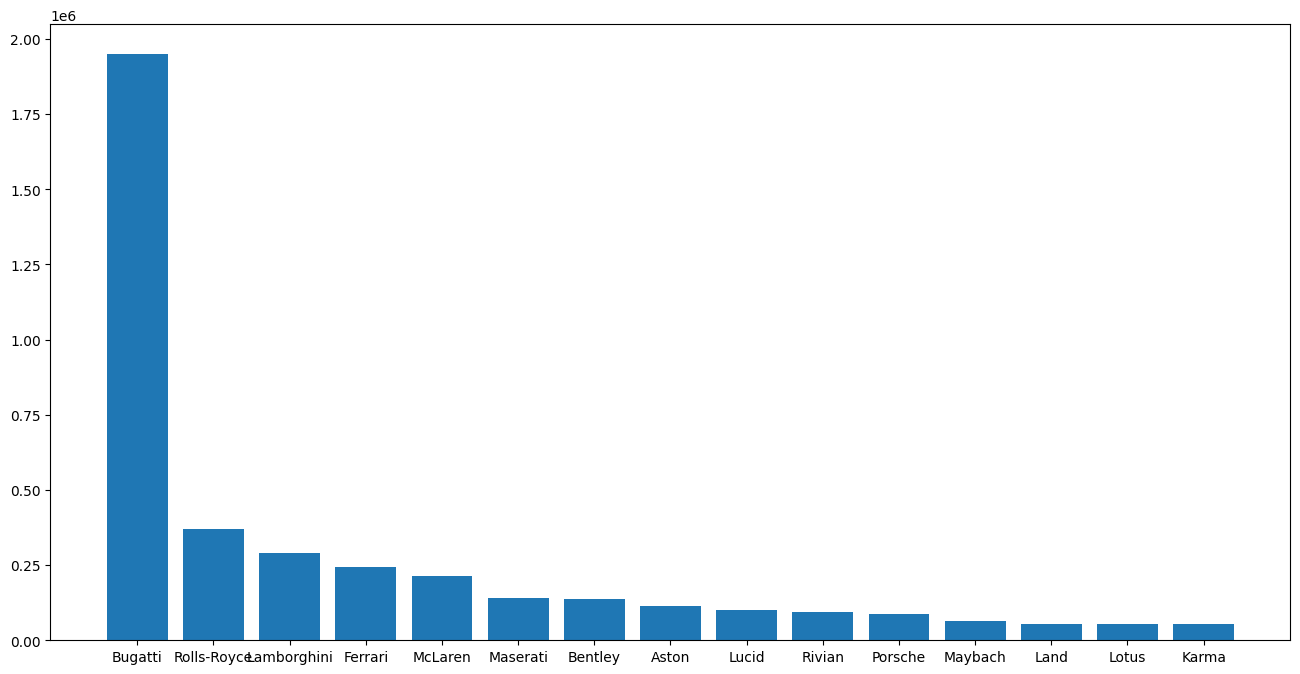

In [1200]:
res = df.groupby("brand").agg({"price":"mean"}).sort_values("price", ascending=False)
values = res.to_numpy().reshape(-1)[0:15]
plt.figure(figsize=(16, 8))
plt.bar(res.index[0:15], values)
luxury_brands = list(res.index[:12])
for i in range(len(df)):
    if df.iloc[i, 0] in (luxury_brands):
        df.iloc[i, 0] = "1"
    else:
        df.iloc[i, 0] = "0"
df["brand"] = df['brand'].astype(int)

Interior color preprocessing

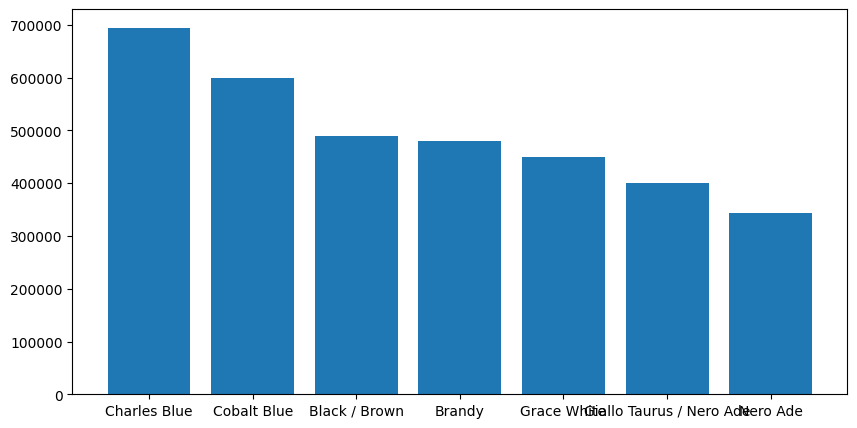

In [1201]:
col_res = df.groupby("int_col").agg({"price":"mean"}).sort_values("price", ascending=False)
col_values = col_res.to_numpy().reshape(-1)[:7]
plt.figure(figsize=(10, 5))
plt.bar(col_res.index[:7], col_values)
luxury_colors = list(col_res.index[:7])
for i in range(len(df)):
    if df.iloc[i, 6] in (luxury_colors):
        df.iloc[i, 6] = "1"
    else:
        df.iloc[i, 6] = "0"
df["int_col"] = df['int_col'].astype(int)

Exterior color preprocessing

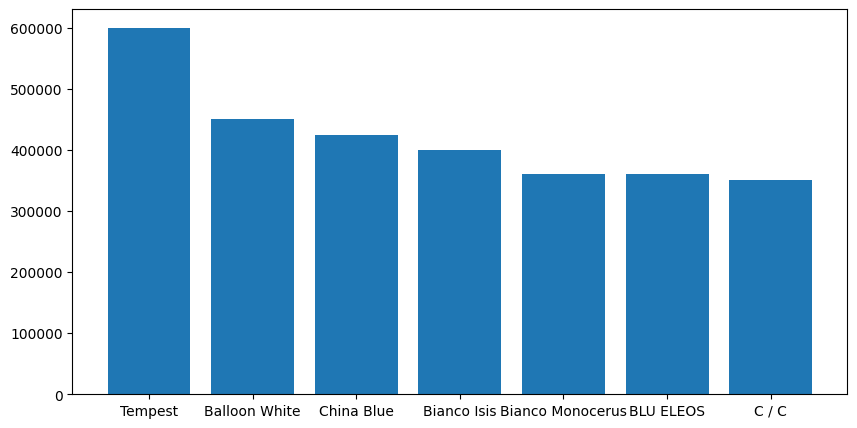

In [1202]:
col_ext_res = df.groupby("ext_col").agg({"price":"mean"}).sort_values("price", ascending=False)
col_ext_values = col_ext_res.to_numpy().reshape(-1)[:7]
plt.figure(figsize=(10, 5))
plt.bar(col_ext_res.index[:7], col_ext_values)

luxury_ext_colors = list(col_ext_res.index[:7])
for i in range(len(df)):
    if df.iloc[i, 5] in (luxury_ext_colors):
        df.iloc[i, 5] = "1"
    else:
        df.iloc[i, 5] = "0"
df["ext_col"] = df['ext_col'].astype(int)

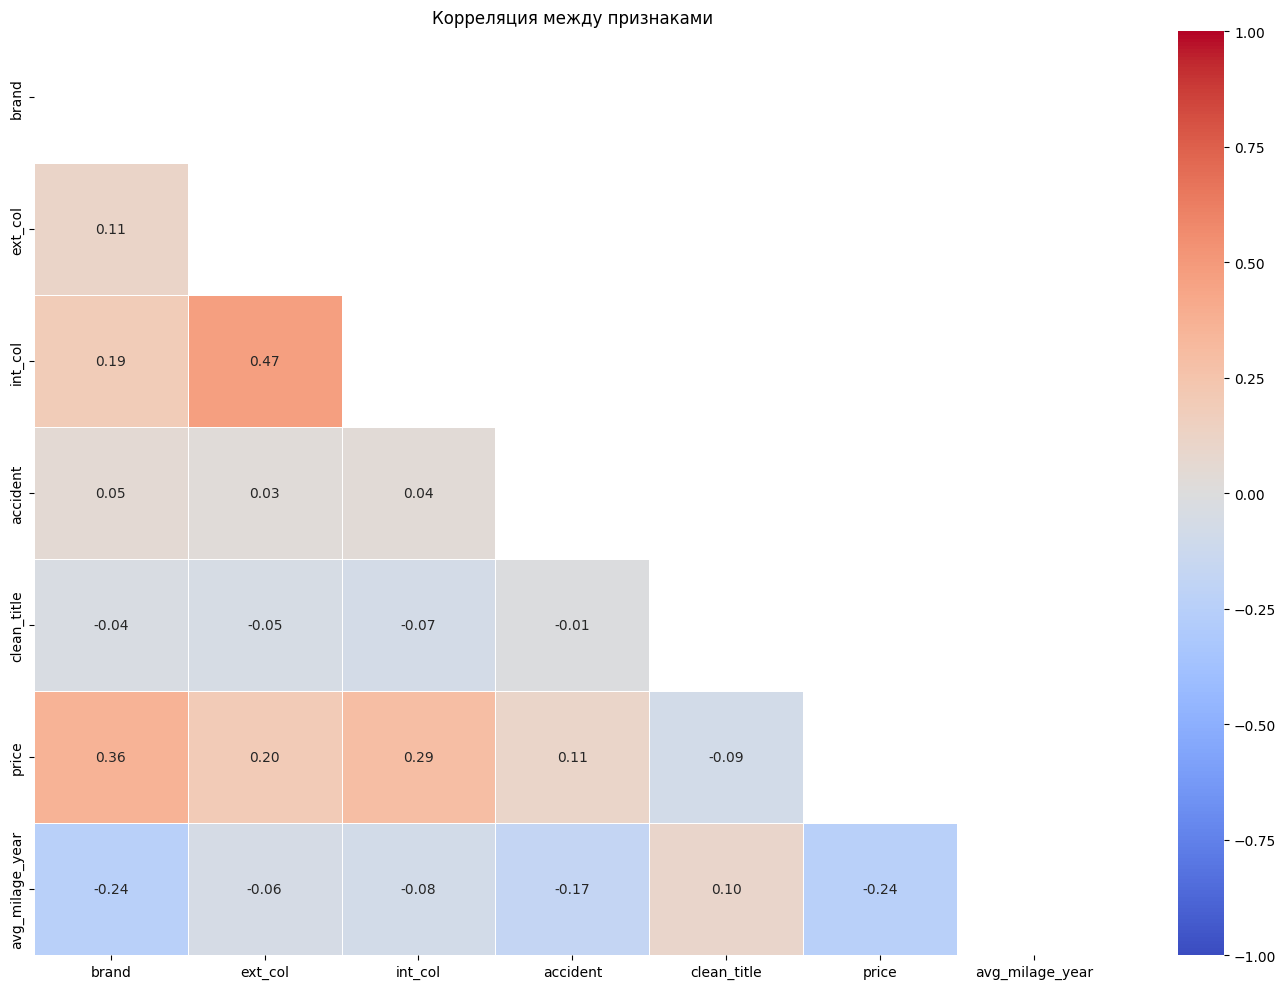

In [1203]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(14, 10))
corr = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=0.5,vmax=1,vmin=-1)
plt.title('Корреляция между признаками')
plt.tight_layout()
plt.show()

Transmission preprocessing

In [1204]:
trans_ind = list(df.columns).index("transmission")
for i in range(len(df)):
    if "A/T" in df.iloc[i, trans_ind] or "Automatic" in df.iloc[i, trans_ind] or "AT" in df.iloc[i, trans_ind] or "Transmission w/Dual Shift Mode" in df.iloc[i, trans_ind] or "CVT Transmission" in df.iloc[i, trans_ind]:
        df.iloc[i, trans_ind] = "automatic"
    elif "M/T" in df.iloc[i, trans_ind] or "Manual" in df.iloc[i, trans_ind] or "Mt" in df.iloc[i, trans_ind]:
        df.iloc[i, trans_ind] = "manual"
    else:
        continue
df = df.drop(index = df[~(df["transmission"] == "automatic") & ~(df["transmission"] == "manual")].index)

Fuel type preprocessing

In [1205]:
df[(df["fuel_type"].isna() == True) & (df["engine"].str.contains("Electric"))]
df["fuel_type"] = df["fuel_type"].fillna("Electric")
df["fuel_type"] = df["fuel_type"].str.replace("not supported", "Electric")
df["fuel_type"] = df["fuel_type"].str.replace("–", "no report")
df = pd.concat((df,pd.get_dummies(df["fuel_type"], drop_first=True)),axis=1)

Engine preprocessing

In [1206]:
pattern = r"(\d\.\dL)\b"
df["engine"] = df['engine'].str.extract(pattern)
df["engine"] = df["engine"].str.replace("L", "")
df = df.reset_index()
str_num = list(df[df["fuel_type"] == "Electric"].index)
engine_ind = list(df.columns).index("engine")
for el in str_num:
    df.iloc[el, engine_ind] = "0"
df["engine"] = pd.to_numeric(df['engine'])
df["engine"] = df["engine"].fillna(df["engine"].median())
df = pd.concat((df, pd.get_dummies(df["transmission"], drop_first=True)), axis=1)

Columns drop

In [1207]:
df = df.drop(columns=["index", "model", "fuel_type", "transmission"])

In [1208]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            3983 non-null   int64  
 1   engine           3983 non-null   float64
 2   ext_col          3983 non-null   int64  
 3   int_col          3983 non-null   int64  
 4   accident         3983 non-null   int64  
 5   clean_title      3983 non-null   int64  
 6   price            3983 non-null   int64  
 7   avg_milage_year  3983 non-null   float64
 8   E85 Flex Fuel    3983 non-null   bool   
 9   Electric         3983 non-null   bool   
 10  Gasoline         3983 non-null   bool   
 11  Hybrid           3983 non-null   bool   
 12  Plug-In Hybrid   3983 non-null   bool   
 13  no report        3983 non-null   bool   
 14  manual           3983 non-null   bool   
dtypes: bool(7), float64(2), int64(6)
memory usage: 276.3 KB


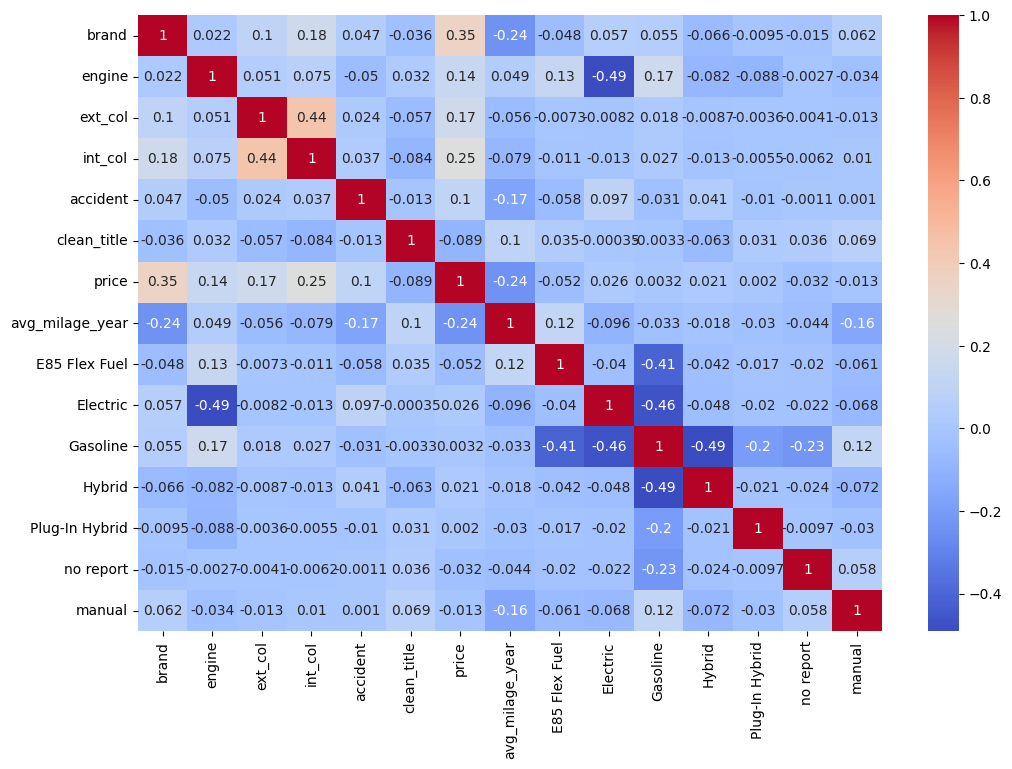

In [1209]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

# Random Forest

In [1210]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["price"]), df["price"], test_size=0.2, random_state = 42)
model = Pipeline((
    ("Scaler", MinMaxScaler()), 
    ("Forest", RandomForestRegressor(random_state=42))
))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
pd.DataFrame({
    'MSE': [mean_squared_error(y_test, y_pred)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred))],
    'MAE': [mean_absolute_error(y_test, y_pred)],
    'R²': [r2_score(y_test, y_pred)],
}, index=['Forest'])

,MSE,RMSE,MAE,R²
Forest,1.677436e+09,40956.516726,20620.258644,0.406499


In [1211]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["price"]), df["price"], test_size=0.2, random_state = 42)
model_lin = Pipeline((
    ("Scaler", MinMaxScaler()), 
    ("Linear", LinearRegression())
))
model_lin.fit(X_train, y_train)
y_pred = model_lin.predict(X_test)

pd.DataFrame({
    'MSE': [mean_squared_error(y_test, y_pred)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred))],
    'MAE': [mean_absolute_error(y_test, y_pred)],
    'R²': [r2_score(y_test, y_pred)],
}, index=['OLS'])

,MSE,RMSE,MAE,R²
OLS,1.724499e+09,41527.088668,23131.258479,0.389847


In [1212]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["price"]), df["price"], test_size=0.2, random_state = 42)
model = Pipeline((
    ("Scaler", MinMaxScaler()), 
    ("tree", DecisionTreeRegressor())
))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
pd.DataFrame({
    'MSE': [mean_squared_error(y_test, y_pred)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred))],
    'MAE': [mean_absolute_error(y_test, y_pred)],
    'R²': [r2_score(y_test, y_pred)],
}, index=['tree'])

,MSE,RMSE,MAE,R²
tree,1.543737e+09,39290.412833,23264.077164,0.453804


Гипотеза не подтвердилась

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


cv = KFold(n_splits=5, shuffle=True, random_state=42)


models_cv = {
    'LinearRegression': LinearRegression(),
    'DecisionTree (d=5)': DecisionTreeRegressor(max_depth=5, random_state=42),
    'RandomForest (d=30)': RandomForestRegressor(max_depth=30, random_state=42)
}


cv_results = []
for name, model in models_cv.items():
 
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
    cv_results.append({'Model': name, 'CV_mean': scores.mean(), 'CV_std': scores.std()})


pd.DataFrame(cv_results).set_index('Model').round(4)

,CV_mean,CV_std
Model,,
LinearRegression,0.2758,0.1058
DecisionTree (d=5),-1.8040,4.3678
RandomForest (d=30),0.1000,0.4993


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],   
    'min_samples_leaf': [1, 2, 4],     
    'max_features': ['sqrt', 'log2']   
}


grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,                
    scoring='r2',        
    n_jobs=-1            
)


grid_search.fit(X_train, y_train)


print("Лучшие параметры:", grid_search.best_params_)
print("Лучший R²:", grid_search.best_score_.round(4))

Лучшие параметры: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Лучший R²: 0.4316


In [1215]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models_reg = {
    'OLS': LinearRegression(),
    'Ridge (α=1)': Ridge(alpha=1),
    'Ridge (α=100)': Ridge(alpha=100),
    'Lasso (α=1)': Lasso(alpha=1),
    'Lasso (α=100)': Lasso(alpha=100),
    'ElasticNet': ElasticNet(alpha=1, l1_ratio=0.5),
}

results_reg = []
for name, model in models_reg.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results_reg.append({
        'Model': name,
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred),
    })

pd.DataFrame(results_reg).set_index('Model').round(2)

,RMSE,MAE,R²
Model,,,
OLS,41527.09,23131.26,0.39
Ridge (α=1),41170.62,23059.30,0.40
Ridge (α=100),42267.00,23824.77,0.37
Lasso (α=1),41518.60,23128.90,0.39
Lasso (α=100),40945.69,22951.87,0.41
ElasticNet,47084.46,26605.63,0.22


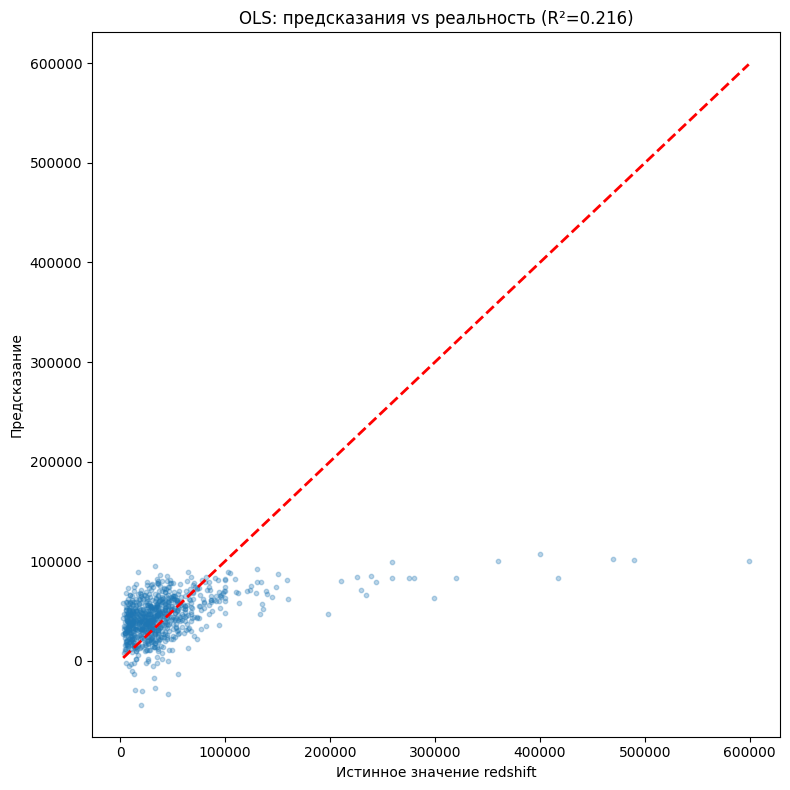

In [1216]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_test, y_pred, alpha=0.3, s=10)
lims = [y_test.min(), y_test.max()]
ax.plot(lims, lims, 'r--', linewidth=2)
ax.set_xlabel('Истинное значение redshift')
ax.set_ylabel('Предсказание')
ax.set_title(f'OLS: предсказания vs реальность (R²={r2_score(y_test, y_pred):.3f})')
plt.tight_layout()
plt.show()

# Гипотеза: Отбор признаков через SelectKBest улучшит качество модели

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import pandas as pd

results = []


for k in range(1, 15):
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    

    selected_features = X_train.columns[selector.get_support()]
    

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    

    results.append({
        'k': k,
        'selected_features': list(selected_features),
        'R2_test': r2_score(y_test, y_pred)
    })


df_results = pd.DataFrame(results)
print(df_results.round(4))

     k                                  selected_features  R2_test
0    1                                            [brand]   0.2356
1    2                                   [brand, int_col]   0.2882
2    3                  [brand, int_col, avg_milage_year]   0.0259
3    4         [brand, ext_col, int_col, avg_milage_year]   0.0275
4    5  [brand, engine, ext_col, int_col, avg_milage_y...   0.3202
5    6  [brand, engine, ext_col, int_col, accident, av...   0.4072
6    7  [brand, engine, ext_col, int_col, accident, cl...   0.4242
7    8  [brand, engine, ext_col, int_col, accident, cl...   0.4246
8    9  [brand, engine, ext_col, int_col, accident, cl...   0.4196
9   10  [brand, engine, ext_col, int_col, accident, cl...   0.4088
10  11  [brand, engine, ext_col, int_col, accident, cl...   0.4016
11  12  [brand, engine, ext_col, int_col, accident, cl...   0.3884
12  13  [brand, engine, ext_col, int_col, accident, cl...   0.3932
13  14  [brand, engine, ext_col, int_col, accident, cl...   0.

Выводы. Оптимальное количество признаков 7-8. При увеличении числа признаков улучшение не достигается. 

# Гипотеза: кодирование бренда автомобился с помощью one-hot encoder брэнда автомобиля увеличит точность модели по сравнении с заменой брэнда на лакшери и остальные

In [1218]:
df["brand"] = df2["brand"]

In [ ]:
df_brands_encoded = pd.get_dummies(df['brand'], prefix='brand')


df = pd.concat([df, df_brands_encoded], axis=1)
df = df.drop('brand', axis=1)

   engine  ext_col  int_col  accident  clean_title  price  avg_milage_year  \
0     3.7        0        0         0            1  10300          4250.00   
1     3.8        0        0         0            1  38005          8685.50   
2     3.5        0        0         1            0  54598          7457.33   
3     3.5        0        0         1            1  15500          8890.00   
4     2.0        0        0         1            0  34999          2458.75   

   E85 Flex Fuel  Electric  Gasoline  ...  brand_Saab  brand_Saturn  \
0           True     False     False  ...       False         False   
1          False     False      True  ...       False         False   
2          False     False      True  ...       False         False   
3          False     False     False  ...       False         False   
4          False     False      True  ...       False         False   

   brand_Scion  brand_Subaru  brand_Suzuki  brand_Tesla  brand_Toyota  \
0        False         False   

In [1220]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["price"]), df["price"], test_size=0.2, random_state = 42)
model = Pipeline((
    ("Scaler", MinMaxScaler()), 
    ("Forest", RandomForestRegressor(random_state=42))
))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
pd.DataFrame({
    'MSE': [mean_squared_error(y_test, y_pred)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred))],
    'MAE': [mean_absolute_error(y_test, y_pred)],
    'R²': [r2_score(y_test, y_pred)],
}, index=['Forest'])

,MSE,RMSE,MAE,R²
Forest,1.745833e+09,41783.17063,20960.9439,0.382299


One-hot-encoding не дал заметного прироста точности

# Если min_samples_leaf слишком маленькое, RandomForestRegressor будет запоминать данные, а далее с увеличением будет увеличиваться обобщающая способность модели, до тех пор пока модель не будет недообучена. 

    max_depth     MSE_train  R2_train      MSE_test   R2_test
0           1  9.284445e+08  0.863974  1.741852e+09  0.383708
1           6  4.389672e+09  0.356871  1.391175e+09  0.507782
2          11  4.831918e+09  0.292077  1.409243e+09  0.501389
3          16  5.104467e+09  0.252146  1.516173e+09  0.463556
4          21  5.253670e+09  0.230287  1.525003e+09  0.460432
5          26  5.340037e+09  0.217633  1.557014e+09  0.449106
6          31  5.421557e+09  0.205690  1.579753e+09  0.441060
7          36  5.479167e+09  0.197249  1.604876e+09  0.432172
8          41  5.523712e+09  0.190723  1.615743e+09  0.428327
9          46  5.567680e+09  0.184281  1.633888e+09  0.421907
10         51  5.585657e+09  0.181647  1.641406e+09  0.419247
11         56  5.604543e+09  0.178880  1.657278e+09  0.413631
12         61  5.619216e+09  0.176731  1.672858e+09  0.408119
13         66  5.632529e+09  0.174780  1.680880e+09  0.405280
14         71  5.642268e+09  0.173353  1.693112e+09  0.400953
15      

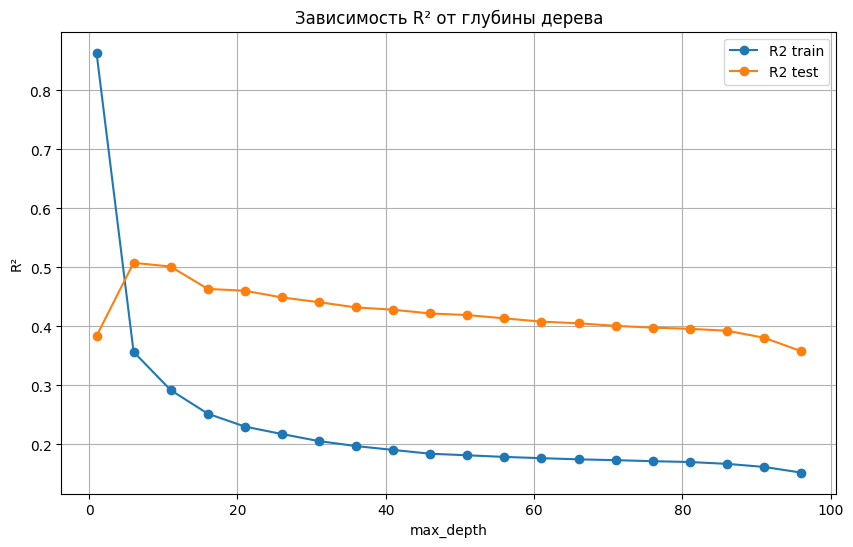

In [1222]:
depths = range(1, 100, 5)
results = []

for d in depths:
    model = RandomForestRegressor(min_samples_leaf=d, random_state=42)
    model.fit(X_train, y_train)
    
    # Метрики на train
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    
    # Метрики на test
    y_test_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    results.append({
        'max_depth': d,
        'MSE_train': mse_train,
        'R2_train': r2_train,
        'MSE_test': mse_test,
        'R2_test': r2_test
    })

df_results = pd.DataFrame(results)
print(df_results)

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df_results['max_depth'], df_results['R2_train'], label='R2 train', marker='o')
plt.plot(df_results['max_depth'], df_results['R2_test'], label='R2 test', marker='o')
plt.xlabel('max_depth')
plt.ylabel('R²')
plt.title('Зависимость R² от глубины дерева')
plt.legend()
plt.grid(True)
plt.show()

Оптимальные значения min_leaf лежат в пределе от 6 до 11. 